In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile 
from pathlib import Path
import os
from tqdm import tqdm
import sys
import napari
sys.path.append(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\10_code\UTvsXCT-preprocessing')
from preprocess_tools import aligner, onlypores, register

# AUX

In [2]:
def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.
    
    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if (f.endswith('.tiff') or f.endswith('.tif'))])
    
    # Get the total number of TIFF files
    total_files = len(tiff_files)
    
    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)
            
            # Update progress
            pbar.update(1)
    
    return np.array(volume)

# Load

In [3]:
filename = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\4\volume_eq_rotated')

data = read_sequence(filename)

Progress: 100%|██████████| 3224/3224 [00:37<00:00, 86.03it/s]


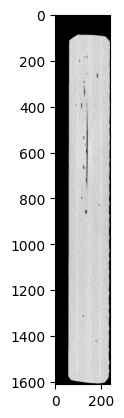

In [4]:
plt.imshow(data[50], cmap='gray')

# Frontwall alignment

In [5]:
mask = onlypores.material_mask(data)

computing otsu


In [6]:
#get the first non zero pixel of each column
first_non_zero = np.argmax(mask, axis=2)

first_non_zero = first_non_zero.reshape(mask.shape[0], mask.shape[1])

frontwall_volume = np.zeros_like(mask)

for i in tqdm(range(frontwall_volume.shape[0])):
    for j in range(frontwall_volume.shape[1]):
        if (first_non_zero[i, j] != 0) or (first_non_zero[i, j] < 80):
            frontwall_volume[i, j, first_non_zero[i, j]] = 1

100%|██████████| 3224/3224 [00:05<00:00, 573.06it/s]


In [7]:
#label the frontwall volume
from scipy.ndimage import label

# Label the frontwall volume
labeled_frontwall, num_features = label(frontwall_volume)

print(f"Number of labeled features: {num_features}")

Number of labeled features: 79713


In [8]:
#get the biggest label
largest_label = np.argmax(np.bincount(labeled_frontwall.flat)[1:]) + 1  # +1 to account for the background label
print(f"Largest label: {largest_label}")

Largest label: 709


In [9]:
#count the number of pixels in the largest label
largest_label_count = np.sum(labeled_frontwall == largest_label)
print(f"Number of pixels in the largest label: {largest_label_count}")

Number of pixels in the largest label: 179900


In [10]:
#put to zero all the other labels
labeled_frontwall[labeled_frontwall != largest_label] = 0

In [11]:
#binarize the labeled frontwall
labeled_frontwall = labeled_frontwall > 0

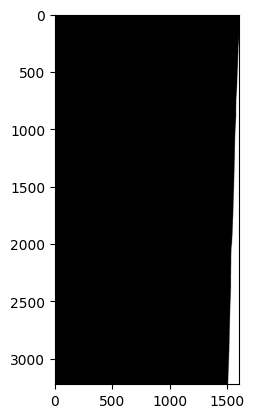

In [12]:
plt.imshow(labeled_frontwall.max(axis=2), cmap='gray')